# Задание 3: Эксперименты и анализ (20 баллов)

Ещё раз извиняюсь,что приходится просто копировать

In [51]:
import torch
import torch.nn as nn

class LinearModel(nn.Module):
    def __init__(self,in_features,out_features):
        super().__init__()
        self.layer1 = nn.Linear(in_features,out_features)
    
    def forward(self,x):
        return self.layer1(x)


#l1_loss 
def l1_loss(output, target, activations, criterion, l1_lambda):
    # Вычисляем основную потерю
    main_loss = criterion(output, target)
    
    # Убедимся, что main_loss - скаляр
    if main_loss.dim() > 0:
        main_loss = main_loss.mean()  # Усредняем, если это не скаляр
    
    # Вычисляем L1-регуляризацию
    l1_penalty = torch.norm(activations, p=1)
    
    # Убедимся, что l1_penalty - скаляр
    if l1_penalty.dim() > 0:
        l1_penalty = l1_penalty.mean()
    
    return main_loss + l1_lambda * l1_penalty


#класс для ранней остановки
class EarlyStopping:
    """"
    patience-количество эпох, которые нужно подождать, прежде чем остановиться, если улучшения не будет.
    delta-Minimum change in the monitored quantity to qualify as an improvement.
    best_score,best_model_state -Track the best validation score and model state.

    
    """
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [52]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import os

class ClassificationMetrics:
    def __init__(self):
        """
        Инициализация класса метрик классификации
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def to_one_hot(self, labels, num_classes):
        """
        Преобразование меток в one-hot encoding
        
        Args:
            labels: тензор меток (batch_size,)
            num_classes: количество классов
            
        Returns:
            one-hot тензор (batch_size, num_classes)
        """
        return torch.nn.functional.one_hot(labels, num_classes).float()

    def precision(self, y_true, y_pred, average='macro'):
        """
        Вычисление метрики Precision
        
        Args:
            y_true: истинные метки (batch_size,)
            y_pred: предсказанные метки (batch_size,)
            average: тип усреднения ('macro', 'micro', 'weighted')
            
        Returns:
            precision score
        """
        y_true = torch.tensor(y_true, dtype=torch.long).to(self.device)
        y_pred = torch.tensor(y_pred, dtype=torch.long).to(self.device)
        
        num_classes = len(torch.unique(y_true))
        
        if average == 'micro':
            true_positives = torch.sum(y_true == y_pred).float()
            predicted_positives = len(y_pred)
            return true_positives / predicted_positives if predicted_positives > 0 else 0
        
        precision_per_class = []
        weights = []
        
        for c in range(num_classes):
            true_positives = torch.sum((y_true == c) & (y_pred == c)).float()
            predicted_positives = torch.sum(y_pred == c).float()
            
            precision = true_positives / predicted_positives if predicted_positives > 0 else 0
            precision_per_class.append(precision)
            
            if average == 'weighted':
                weights.append(torch.sum(y_true == c).float() / len(y_true))
        
        precision_per_class = torch.tensor(precision_per_class)
        
        if average == 'macro':
            return torch.mean(precision_per_class).item()
        elif average == 'weighted':
            return torch.sum(precision_per_class * torch.tensor(weights)).item()
        
        return precision_per_class.tolist()

    def recall(self, y_true, y_pred, average='macro'):
        """
        Вычисление метрики Recall
        
        Args:
            y_true: истинные метки (batch_size,)
            y_pred: предсказанные метки (batch_size,)
            average: тип усреднения ('macro', 'micro', 'weighted')
            
        Returns:
            recall score
        """
        y_true = torch.tensor(y_true, dtype=torch.long).to(self.device)
        y_pred = torch.tensor(y_pred, dtype=torch.long).to(self.device)
        
        num_classes = len(torch.unique(y_true))
        
        if average == 'micro':
            true_positives = torch.sum(y_true == y_pred).float()
            actual_positives = len(y_true)
            return true_positives / actual_positives if actual_positives > 0 else 0
        
        recall_per_class = []
        weights = []
        
        for c in range(num_classes):
            true_positives = torch.sum((y_true == c) & (y_pred == c)).float()
            actual_positives = torch.sum(y_true == c).float()
            
            recall = true_positives / actual_positives if actual_positives > 0 else 0
            recall_per_class.append(recall)
            
            if average == 'weighted':
                weights.append(torch.sum(y_true == c).float() / len(y_true))
        
        recall_per_class = torch.tensor(recall_per_class)
        
        if average == 'macro':
            return torch.mean(recall_per_class).item()
        elif average == 'weighted':
            return torch.sum(recall_per_class * torch.tensor(weights)).item()
        
        return recall_per_class.tolist()

    def f1_score(self, y_true, y_pred, average='macro'):
        """
        Вычисление метрики F1-score
        
        Args:
            y_true: истинные метки (batch_size,)
            y_pred: предсказанные метки (batch_size,)
            average: тип усреднения ('macro', 'micro', 'weighted')
            
        Returns:
            f1 score
        """
        precision = self.precision(y_true, y_pred, average)
        recall = self.recall(y_true, y_pred, average)
        
        if average in ['macro', 'weighted']:
            return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        elif average == 'micro':
            return precision
        
        f1_scores = []
        for p, r in zip(precision, recall):
            f1 = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
            f1_scores.append(f1)
        return f1_scores

    def roc_auc(self, y_true, y_scores, multi_class='ovr'):
        """
        Вычисление метрики ROC-AUC
        
        Args:
            y_true: истинные метки (batch_size,)
            y_scores: вероятности предсказаний (batch_size, num_classes)
            multi_class: 'ovr' (one-vs-rest) или 'ovo' (one-vs-one)
            
        Returns:
            roc-auc score
        """
        y_true = torch.tensor(y_true, dtype=torch.long).cpu().numpy()
        y_scores = torch.tensor(y_scores, dtype=torch.float).cpu().numpy()
        
        num_classes = y_scores.shape[1]
        y_true_one_hot = self.to_one_hot(torch.tensor(y_true), num_classes).cpu().numpy()
        
        auc_scores = []
        
        if multi_class == 'ovr':
            for i in range(num_classes):
                fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_scores[:, i])
                auc_score = auc(fpr, tpr)
                auc_scores.append(auc_score)
            return np.mean(auc_scores)
        
        elif multi_class == 'ovo':
            auc_sum = 0
            n_pairs = 0
            for i in range(num_classes):
                for j in range(i+1, num_classes):
                    mask = np.logical_or(y_true == i, y_true == j)
                    y_true_binary = (y_true[mask] == i).astype(int)
                    y_scores_binary = y_scores[mask, i] / (y_scores[mask, i] + y_scores[mask, j])
                    fpr, tpr, _ = roc_curve(y_true_binary, y_scores_binary)
                    auc_sum += auc(fpr, tpr)
                    n_pairs += 1
            return auc_sum / n_pairs if n_pairs > 0 else 0
        
        return auc_scores

    def confusion_matrix(self, y_true, y_pred, plot=True, save_path=None):
        """
        Вычисление и визуализация confusion matrix с возможностью сохранения
        
        Args:
            y_true: истинные метки (batch_size,)
            y_pred: предсказанные метки (batch_size,)
            plot: флаг для отображения визуализации
            save_path: путь для сохранения графика (например, 'confusion_matrix.png')
            
        Returns:
            confusion matrix
        """
        y_true = torch.tensor(y_true, dtype=torch.long).to(self.device)
        y_pred = torch.tensor(y_pred, dtype=torch.long).to(self.device)
        
        num_classes = len(torch.unique(y_true))
        cm = torch.zeros((num_classes, num_classes), dtype=torch.long)
        
        for t, p in zip(y_true, y_pred):
            cm[t, p] += 1
        
        if plot:
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm.numpy(), annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            
            if save_path:
                # Создаём директорию, если она не существует
                os.makedirs(os.path.dirname(save_path), exist_ok=True)
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
                print(f"Confusion matrix сохранена в {save_path}")
            
            plt.show()
            plt.close()
        
        return cm


In [ ]:
from torch.utils.data import Dataset
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import numpy as np
import torch

class CustomDataset(Dataset):
    def __init__(self, path_file, numeric_columns: list, string_columns: list, binary_columns: list, target_column: str):
        self.path_file = path_file
        self.numeric_columns = numeric_columns
        self.string_columns = string_columns
        self.binary_columns = binary_columns
        self.target_column = target_column
        self.label_encoders = {}
        self.one_hot_encoders = {}

        self.df = pd.read_csv(path_file)
        self.df = self.df.dropna()

        self._convert_numeric()
        self._convert_string()
        self._convert_binary()

    def _convert_numeric(self):
        if self.numeric_columns:
            scaler = StandardScaler()
            self.df[self.numeric_columns] = scaler.fit_transform(self.df[self.numeric_columns])

    def _convert_string(self):
        if self.string_columns:
            for column in self.string_columns:
                le = LabelEncoder()
                self.df[column] = self.df[column].fillna('missing')
                self.df[column] = le.fit_transform(self.df[column])
                self.label_encoders[column] = le

    def _convert_binary(self):
        if self.binary_columns:
            for column in self.binary_columns:
                encoder = OneHotEncoder(sparse_output=False, drop='first')
                transformed = encoder.fit_transform(self.df[[column]])
                new_columns = [f"{column}_{cat}" for cat in encoder.categories_[0][1:]]
                self.df[new_columns] = transformed
                self.df = self.df.drop(column, axis=1)
                self.one_hot_encoders[column] = encoder

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        data_one_row = self.df.iloc[index]
        train = data_one_row.drop(self.target_column).values.astype(np.float32)  # Преобразуем в numpy float32
        target = np.array(data_one_row[self.target_column], dtype=np.float32)  # Преобразуем в numpy float32
        return torch.tensor(train), torch.tensor(target)  # Возвращаем тензоры

3.2 Feature Engineering (10 баллов)

<h3>Описание названия колонок:</h3>
<ul>
<li>survival - Выживание (0 = Нет; 1 = Да)</li>
<li>pclass - Класс пассажира (1 = 1-й; 2 = 2-й; 3 = 3-й)</li>
<li>name - Имя</li>
<li>sex - Пол</li>
<li>age - Возраст</li>
<li>sibsp - Количество братьев/сестер или супругов на борту</li>
<li>parch - Количество родителей/детей на борту</li>
<li>ticket - Номер билета</li>
<li>fare - Стоимость билета пассажира</li>
<li>cabin - Каюта</li>
<li>embarked - Порт посадки (C = Шербур; Q = Квинстаун; S = Саутгемптон)</li>
</ul>

In [28]:
import pandas as pd
df = pd.read_csv("data/Titanic-Dataset.csv")
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [29]:
# Проверяем наличие пустых значений в DataFrame
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

В колонке Embarked всего 2 пропущенных поля. Те строки, где они встречаются можно убрать

In [30]:
# Убираем те строки, где нет значения у стобца Embarked 
df = df.dropna(axis=0, subset=['Embarked'])


У нас очень много пропусков в колонке Cabin. Всего мы имеем 891 строку из которых 687  не имеют значение Cabin, и того всего 204 строк, где есть значения Cabin. Было решено просто убрать этот столбец.


In [31]:
# Убираем колонку Cabin
df = df.drop(columns=['Cabin'])

Также 177 пропусков у колоник Age. Пустые колонки Age заполнил средним значением всего столбца Age (Средний возраст - 28 лет). 

In [9]:
# просмотр среднего возраста:
print(f"Средний возраст: {df['Age'].median()}")

Средний возраст: 28.0


In [32]:
# заполняем в столбце age пустые ячейки средним возростом(28 лет)
df['Age'] = df['Age'].fillna(df['Age'].median())

In [33]:
# проверяем, что теперь наш датафрейм не имеет пустых значений
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [34]:
# Получаем общую информацию о DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


# <b>Анализ Датасета</b>

In [35]:
# Создаем копию DataFrame для анализа, оставляя оригинальный DataFrame для добавления новых признаков(feature engineering)
df_for_analysis = df.copy()

In [36]:
from sklearn.preprocessing import LabelEncoder

# Выбираем категориальные столбцы в DataFrame(те, которые не имеют тип float или int)
cathegorical_columns = df.select_dtypes(include=['object']).columns


for col in cathegorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,108,1,22.0,1,0,522,7.2500,2
1,2,1,1,190,0,38.0,1,0,595,71.2833,0
2,3,1,3,353,0,26.0,0,0,668,7.9250,2
3,4,1,1,272,0,35.0,1,0,48,53.1000,2
4,5,0,3,15,1,35.0,0,0,471,8.0500,2


## Возраст и выживаемость

Создал разные возрастные группы: 0-10, 10-20, 20-30, 30-40, 40-50, 50+ лет для упрощения анализа влияние возраста на выживаемость

C:\Users\artur\AppData\Local\Temp\ipykernel_24464\3097517706.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival_by_age = df_for_analysis.groupby(['AgeGroup', 'Survived']).size().unstack()


<Figure size 3200x1800 with 0 Axes>

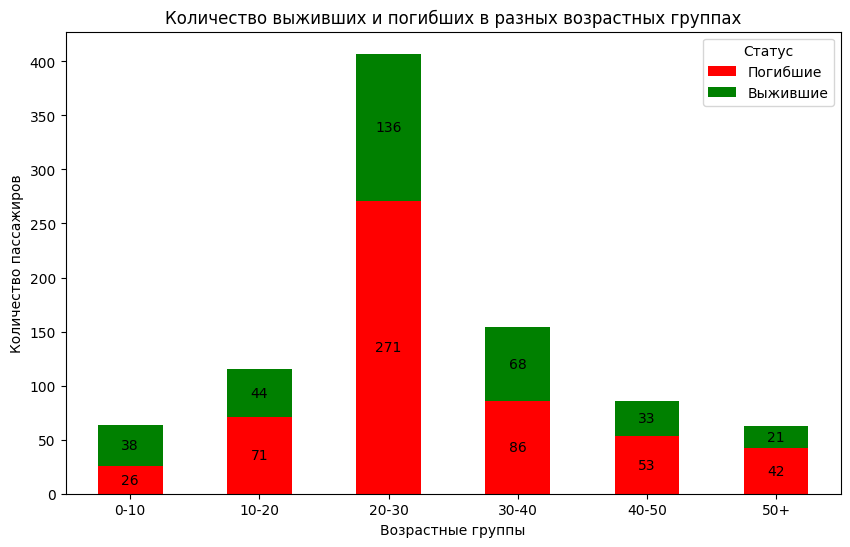

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,9),dpi=200)

# Создаем возрастные группы
bins = [0, 10, 20, 30, 40, 50, 100]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50+']

df_for_analysis['AgeGroup'] = pd.cut(df_for_analysis['Age'], bins, labels=labels)

# Группируем данные по возрастным группам и статусу выживания
survival_by_age = df_for_analysis.groupby(['AgeGroup', 'Survived']).size().unstack()

# Рисуем график
ax = survival_by_age.plot(kind='bar', stacked=True, color=['red', 'green'], figsize=(10, 6))

plt.xlabel('Возрастные группы')
plt.ylabel('Количество пассажиров')
plt.title('Количество выживших и погибших в разных возрастных группах')
plt.legend(['Погибшие', 'Выжившие'], title='Статус')
plt.xticks(rotation=0)


# Добавляем аннотации на столбцы
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x + width/2,
            y + height/2,
            '{:.0f}'.format(height),
            horizontalalignment='center',
            verticalalignment='center');

<h3>Выводы:</h3>

<ul>
<li>В возрастной группе 0-10 лет выживших больше, чем погибших (39 выживших против 26 погибших или же 59.7%). Это может быть связано с приоритетом спасения детей.</li>
<li>В возрастной группе 10-20 лет количество погибших значительно превышает количество выживших (71 погибших против 44 выживших или же 38.3%).</li>
<li>В возрастной группе 20-30 лет наблюдается наибольшее количество пассажиров, при этом количество погибших значительно превышает количество выживших (271 погибших против 136 выживших или же 33.6%).</li>
<li>В возрастной группе 30-40 лет количество погибших также превышает количество выживших (86 погибших против 66 выживших или же 43.4%).</li>
<li>В возрастной группе 40-50 лет количество погибших превышает количество выживших (53 погибших против 33 выживших или же 38.4%).</li>
<li>В возрастной группе 50+ количество погибших превышает количество выживших (42 погибших против 21 выживших или же 33.3%).</li>
</ul>

График показывает, что шансы на выживание могут зависеть от возраста пассажира. Младшие возрастные группы (0-10) имеют более высокие шансы на выживание, что может быть связано с приоритетом спасения детей.

In [38]:
# Добавление нового признака в исходный датафрейм
df['Age_priority'] = df_for_analysis['AgeGroup'].apply(lambda x: 1 if x == '0-10' else 0)
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_priority
0,1,0,3,108,1,22.0,1,0,522,7.2500,2,0
1,2,1,1,190,0,38.0,1,0,595,71.2833,0,0
2,3,1,3,353,0,26.0,0,0,668,7.9250,2,0
3,4,1,1,272,0,35.0,1,0,48,53.1000,2,0
4,5,0,3,15,1,35.0,0,0,471,8.0500,2,0
5,6,0,3,553,1,28.0,0,0,274,8.4583,1,0
6,7,0,1,514,1,54.0,0,0,84,51.8625,2,0
7,8,0,3,623,1,2.0,3,1,394,21.0750,2,1
8,9,1,3,411,0,27.0,0,2,343,11.1333,2,0
9,10,1,2,575,0,14.0,1,0,131,30.0708,0,0


## Пол и выживаемость

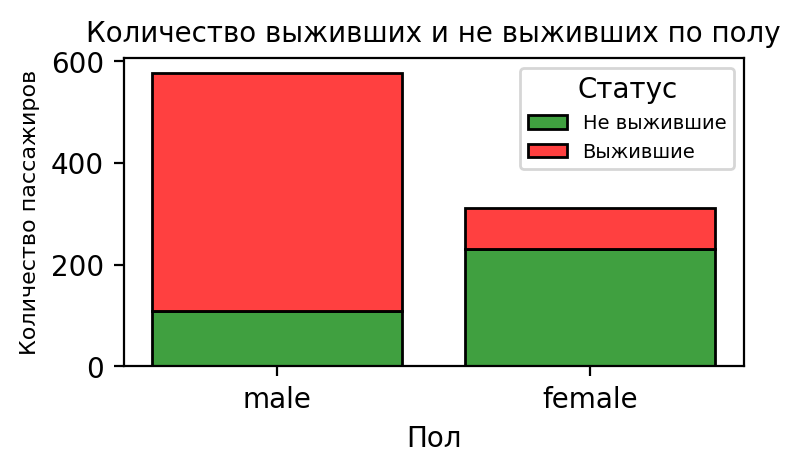

In [39]:
import seaborn as sns

plt.figure(figsize=(4,2),dpi=200)

# График для выживших и не выживших
sns.histplot(data=df_for_analysis, x='Sex', hue='Survived', multiple='stack', palette=['red', 'green'], shrink=0.8)

# Добавляем заголовки и метки
plt.xlabel('Пол')
plt.xticks([0,1])
plt.ylabel('Количество пассажиров', fontsize=8)
plt.title('Количество выживших и не выживших по полу', fontsize=10)
plt.legend(title='Статус', labels=['Не выжившие', 'Выжившие'], fontsize=7)

# Показываем график
plt.show()

<h3>Выводы:</h3> 
<ul> 
<li>
График показывает, что количество выживших женщин (около 230) значительно превышает количество не выживших женщин (около 80). Это указывает на высокий процент выживших среди женщин.</li> <li>Для мужчин, наоборот, количество не выживших (около 460) значительно превышает количество выживших (около 100). Это указывает на низкий процент выживших среди мужчин.
</li> 
<li>
Это может быть связано с приоритетом спасения женщин и детей, который традиционно применялся при эвакуации с корабля.</li> 

</ul>
.

## Наличие детей и выживаемость

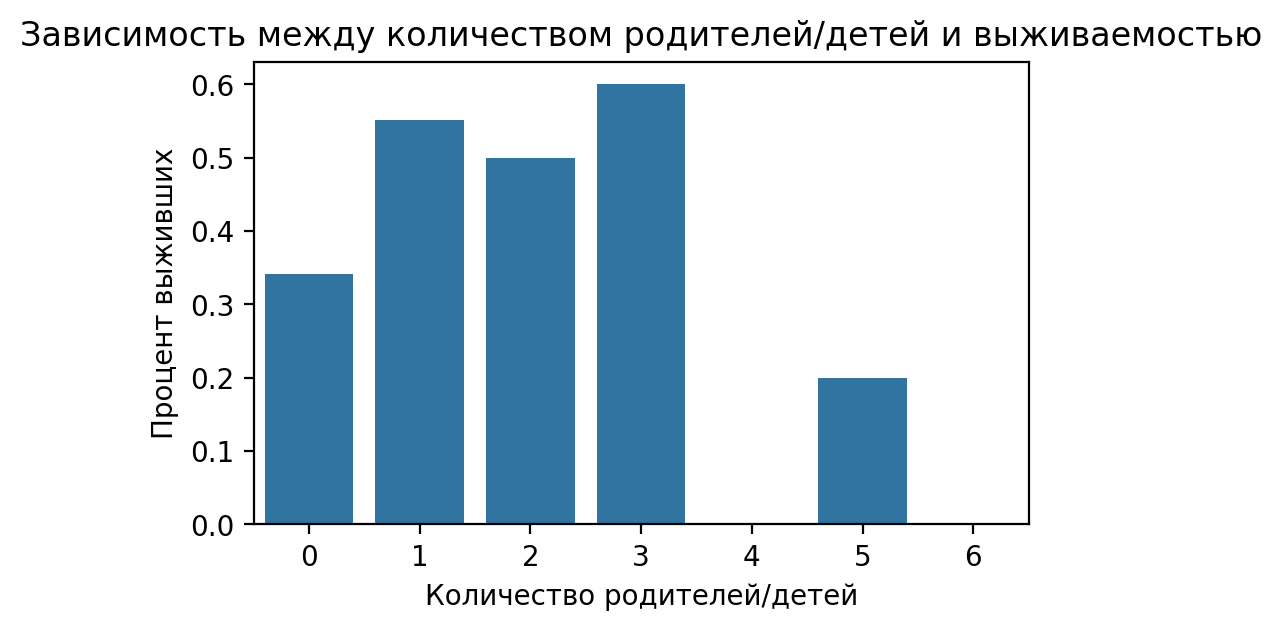

In [40]:
plt.figure(figsize=(5, 3), dpi=200)

# График зависимости между Parch и выживаемостью
sns.barplot(data=df_for_analysis, x='Parch', y='Survived', errorbar=None)

plt.xlabel('Количество родителей/детей');
plt.ylabel('Процент выживших');
plt.title('Зависимость между количеством родителей/детей и выживаемостью');


<h3>Выводы:</h3> 
<ul> 

<li>
График показывает, что процент выживших пассажиров изменяется в зависимости от количества родителей/детей (Parch).
</li> 

<li>
Пассажиры с 1-3 родителями/детьми имели более высокие шансы на выживание (около 50-60%).
</li> 

<li>
Пассажиры без родителей/детей или с большим количеством родителей/детей (5 и более) имели меньшие шансы на выживание (около 20-30%).
</li> 

</ul>

In [41]:
# Создаем новый признак 'Have_1_2_3_Parch'
df['Has_1_to_3_Parch'] = df['Parch'].apply(lambda x: 1 if x in [1, 2, 3] else 0)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_priority,Has_1_to_3_Parch
0,1,0,3,108,1,22.0,1,0,522,7.2500,2,0,0
1,2,1,1,190,0,38.0,1,0,595,71.2833,0,0,0
2,3,1,3,353,0,26.0,0,0,668,7.9250,2,0,0
3,4,1,1,272,0,35.0,1,0,48,53.1000,2,0,0
4,5,0,3,15,1,35.0,0,0,471,8.0500,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,547,1,27.0,0,0,100,13.0000,2,0,0
887,888,1,1,303,0,19.0,0,0,14,30.0000,2,0,0
888,889,0,3,412,0,28.0,1,2,674,23.4500,2,0,1
889,890,1,1,81,1,26.0,0,0,8,30.0000,0,0,0


## Pclass и выживаемость

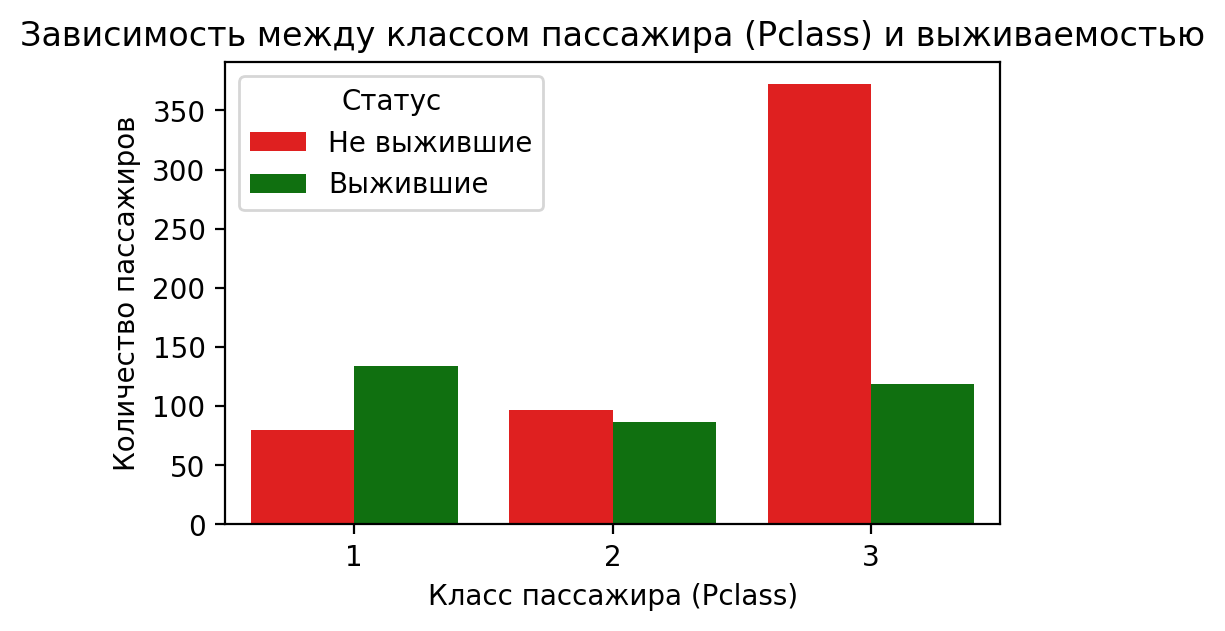

In [42]:
# Создаем фигуру и ось
plt.figure(figsize=(5, 3), dpi=200)

# График зависимости между Pclass и выживаемостью
sns.countplot(data=df_for_analysis, x='Pclass', hue='Survived', palette=['red', 'green'])

plt.xlabel('Класс пассажира (Pclass)')
plt.ylabel('Количество пассажиров')
plt.title('Зависимость между классом пассажира (Pclass) и выживаемостью')
plt.legend(title='Статус', labels=['Не выжившие', 'Выжившие'])

<h3>Выводы:</h3> 
<ul> 
<li>График показывает, что количество выживших пассажиров значительно выше в первом классе (Pclass=1) по сравнению с вторым и третьим классами.</li> 
<li>Количество не выживших пассажиров значительно выше в третьем классе (Pclass=3) по сравнению с первым и вторым классами.</li> 

<li>Пассажиры второго класса имели средние шансы на выживание.</li> 
<li>Это может быть связано с расположением первого, второго и третьего класса.</li> 
<li>Анализ зависимости между классом пассажира (Pclass) и выживаемостью является важным аспектом для понимания динамики выживания на Титанике и может быть полезен для дальнейших исследований и моделирования.</li> 
</ul>

In [43]:
# Создаем новый признак 'Is_First_Class'
df['Is_First_Class'] = df['Pclass'].apply(lambda x: 1 if x == 1 else 0)

df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_priority,Has_1_to_3_Parch,Is_First_Class
0,1,0,3,108,1,22.0,1,0,522,7.2500,2,0,0,0
1,2,1,1,190,0,38.0,1,0,595,71.2833,0,0,0,1
2,3,1,3,353,0,26.0,0,0,668,7.9250,2,0,0,0
3,4,1,1,272,0,35.0,1,0,48,53.1000,2,0,0,1
4,5,0,3,15,1,35.0,0,0,471,8.0500,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,547,1,27.0,0,0,100,13.0000,2,0,0,0
887,888,1,1,303,0,19.0,0,0,14,30.0000,2,0,0,1
888,889,0,3,412,0,28.0,1,2,674,23.4500,2,0,1,0
889,890,1,1,81,1,26.0,0,0,8,30.0000,0,0,0,1


In [44]:
#также удалим колонки PassengerId,Ticket,Name
df =df.drop(["PassengerId","Ticket","Name"],axis =1)

In [45]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_priority,Has_1_to_3_Parch,Is_First_Class
0,0,3,1,22.0,1,0,7.2500,2,0,0,0
1,1,1,0,38.0,1,0,71.2833,0,0,0,1
2,1,3,0,26.0,0,0,7.9250,2,0,0,0
3,1,1,0,35.0,1,0,53.1000,2,0,0,1
4,0,3,1,35.0,0,0,8.0500,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,2,0,0,0
887,1,1,0,19.0,0,0,30.0000,2,0,0,1
888,0,3,0,28.0,1,2,23.4500,2,0,1,0
889,1,1,1,26.0,0,0,30.0000,0,0,0,1


In [46]:
df.to_csv("data/titanic_new.csv")

Проверка обучения на разных датасетах

In [53]:
from torch.utils.data import DataLoader,SubsetRandomSampler
from sklearn.model_selection import train_test_split

import torch.optim as optim
dataset = CustomDataset(path_file="data/titanic_new.csv",numeric_columns=["Age","Fare"],string_columns=[],binary_columns=[]
                       
                        ,target_column="Survived")



batch_size: int = 32,
num_epochs: int = 100,
learning_rate = 0.001,
l1_lambda: float = 0.01,
patience: int = 5,
validation_split: float = 0.2
lr = 0.001

in_features = len(dataset.df.columns) - 1  # Все колонки, кроме целевой
out_features = 1 


model = LinearModel(in_features, out_features)
criterion = nn.BCEWithLogitsLoss()  # Функция потерь для регрессии
optimizer = torch.optim.Adam(params =model.parameters(), lr=lr)

    # Разделяем данные на обучающую и валидационную выборки
dataset_size = len(dataset)
indices = list(range(dataset_size))
train_indices, val_indices = train_test_split(
        indices, test_size=validation_split, random_state=42
    )

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)

    # Инициализируем раннюю остановку
early_stopping = EarlyStopping(patience=patience, delta=0)

    # Обучение
print("Starting training...")
for epoch in range(100):
        # Обучающий режим
        model.train()
        train_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to( dtype=torch.float32), target.to(dtype=torch.float32)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.view(-1, 1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # Валидация
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to( dtype=torch.float32), target.to( dtype=torch.float32)
                output = model(data)
                loss = criterion(output, target.view(-1, 1))  # Только MSE для валидации
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

       

   

Starting training...
Epoch 1/(100,), Train Loss: 69.584598, Val Loss: 71.052625
Epoch 2/(100,), Train Loss: 62.710257, Val Loss: 61.520761
Epoch 3/(100,), Train Loss: 57.724098, Val Loss: 56.359241
Epoch 4/(100,), Train Loss: 50.213704, Val Loss: 49.292749
Epoch 5/(100,), Train Loss: 44.515568, Val Loss: 43.235822
Epoch 6/(100,), Train Loss: 38.958932, Val Loss: 36.097689
Epoch 7/(100,), Train Loss: 31.930386, Val Loss: 29.565714
Epoch 8/(100,), Train Loss: 25.667605, Val Loss: 22.823729
Epoch 9/(100,), Train Loss: 18.964085, Val Loss: 17.453205
Epoch 10/(100,), Train Loss: 12.941646, Val Loss: 10.217090
Epoch 11/(100,), Train Loss: 6.654769, Val Loss: 3.993094
Epoch 12/(100,), Train Loss: 1.709643, Val Loss: 0.883140
Epoch 13/(100,), Train Loss: 0.817429, Val Loss: 0.770329
Epoch 14/(100,), Train Loss: 0.700139, Val Loss: 0.745072
Epoch 15/(100,), Train Loss: 0.700883, Val Loss: 0.739015
Epoch 16/(100,), Train Loss: 0.700576, Val Loss: 0.747464
Epoch 17/(100,), Train Loss: 0.690045, V

В прошлой части на валидации было 6-7,сейчас 0.52 ,заметное изменение